# Time Series Analysis Techniques for Volume Indicators

Volume indicators track the flow of trading volume to assess the strength or weakness of price movements. Analyzing volume through time series techniques enhances signal detection for trends, reversals, and volatility.

<br>

## 1. Moving Averages (MA)

**Purpose:** Smooth out short-term fluctuations in volume data to reveal underlying trends.

### Types:
- **Simple Moving Average (SMA):**

SMA_t = (V_{t-n+1} + ... + V_t) / n

- **Exponential Moving Average (EMA):**
Puts more weight on recent values.

### Use Cases:
- Detect average volume over time.
- Compare with price MA to confirm trend strength.
- Spot volume surges relative to average levels.



# Install required packages
`pip install yfinance matplotlib pandas statsmodels seaborn`

In [10]:
# 📥 Load Sample Data
import yfinance as yf
import pandas as pd

# Download sample stock data (Apple Inc.) for two years
data = yf.download('AAPL', start='2021-01-01', end='2023-01-01')
volume = data['Volume']
volume.name = "Volume"
volume.head()

/tmp/ipython-input-10-3386995611.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2021-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2021-01-04,143301900
2021-01-05,97664900
2021-01-06,155088000
2021-01-07,109578200
2021-01-08,105158200


## Moving Average (Simple & Exponential)
Smooths volume fluctuations to highlight trends.

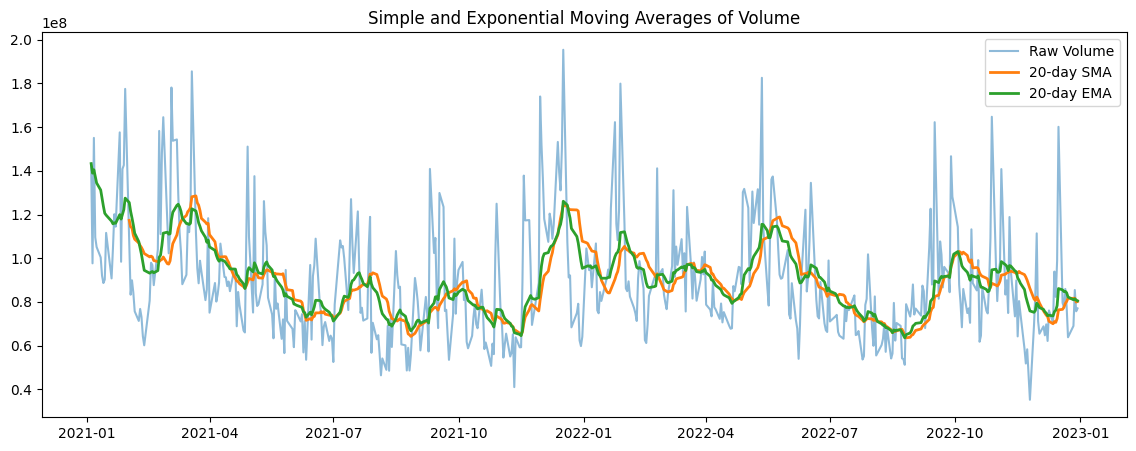

In [11]:
volume_sma = volume.rolling(window=20).mean()
volume_ema = volume.ewm(span=20, adjust=False).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(volume, label='Raw Volume', alpha=0.5)
plt.plot(volume_sma, label='20-day SMA', linewidth=2)
plt.plot(volume_ema, label='20-day EMA', linewidth=2)
plt.legend()
plt.title('Simple and Exponential Moving Averages of Volume')
plt.show()

**Output Plot:**
- Line plot of raw volume data with overlaid Simple Moving Average (SMA) and Exponential Moving Average (EMA).

**Explanation:**
- The **SMA** smooths the volume over a 20-day window, highlighting longer-term volume trends.
- The **EMA** gives more weight to recent volume data and responds faster to sudden changes.
- Use case: Detect sustained increases or drops in trading activity.


##  2. Autoregressive Integrated Moving Average (ARIMA)

**Purpose:** Forecast future volume based on past values and trends.

### General Form:
ARIMA(p, d, q)

- `p`: Autoregressive order  
- `d`: Degree of differencing  
- `q`: Moving average order

### Use Case:
- Model and forecast expected volume trends.
- Detect abnormal volume deviations (e.g., unusual spikes).




/tmp/ipython-input-12-4096679505.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2022-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, fre

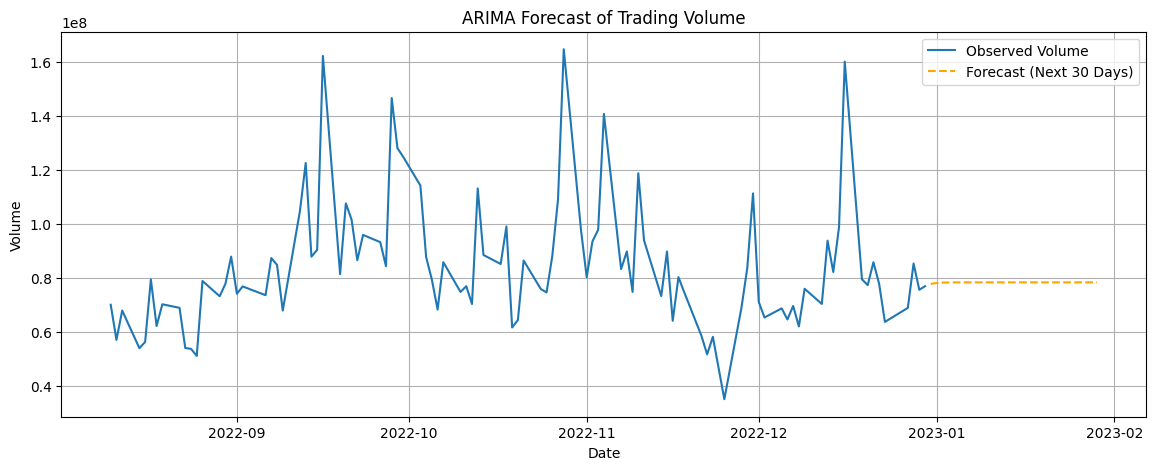

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf

# Load data
data = yf.download("AAPL", start="2022-01-01", end="2023-01-01")
volume = data['Volume'].copy()

# Optional: smooth very small or zero values for log transformation
volume = volume.replace(0, np.nan).dropna()
volume_log = np.log(volume)

# Fit ARIMA model (example: ARIMA(1,1,1))
model = ARIMA(volume_log, order=(1, 1, 1))
results = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast_log = results.forecast(steps=forecast_steps)
forecast = np.exp(forecast_log)  # revert log transform

# Create date index for the forecast
last_date = volume.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)

# Plot observed and forecasted values
plt.figure(figsize=(14, 5))
plt.plot(volume[-100:], label='Observed Volume')
plt.plot(forecast_index, forecast, label='Forecast (Next 30 Days)', linestyle='--', color='orange')
plt.title('ARIMA Forecast of Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()



### What the Plot Shows:
- **Observed Volume (Blue Line):**  
  The actual historical trading volume over the most recent 100 days.

- **Forecasted Volume (Orange Dashed Line):**  
  The next 30 days of predicted trading volume generated by the ARIMA(1,1,1) model.

<br>

### Interpretation:

1. **Forecast Behavior:**
   - If the orange line shows a **steady increase**, the model expects rising market activity.
   - If it trends **flat**, it suggests stable volume.
   - **Dips** may indicate an expected drop in trading interest or market consolidation.

2. **Trend Continuation:**
   - ARIMA assumes the historical trend continues unless the data has strong seasonality (which ARIMA alone does not explicitly model).
   - The forecast captures **autocorrelations** in the volume series, learning from past lagged relationships.

3. **Volatility Insight:**
   - Sudden spikes or sharp movements in the forecast could suggest potential **market-moving events** if corroborated by news or technical signals.



# 3. Machine Learning on Volume Data

### Examples:
- **LSTM (Long Short-Term Memory)**: For sequential deep learning on volume trends
- **Random Forest / XGBoost**: For volume-driven price prediction
- **Clustering (e.g., K-Means)**: Identify volume regimes

### Use in Finance:

  - Predicting liquidity availability.
  - Supporting volume-weighted execution strategies.
  - Feeding forecasts into multi-factor price prediction models.

- Can be extended by including more features like:
  - Price-based indicators (e.g., RSI, MACD)
  - Calendar features (day of week/month)
  - External factors (news sentiment, earnings, etc.)

<br>

We use a supervised learning model to predict daily trading volume based on the past 5 days of volume (lags):


- **Model Used:** `RandomForestRegressor` with 100 decision trees.
- **RMSE (Root Mean Squared Error):**  
  Indicates the average prediction error in volume units.  
  Lower RMSE = better predictive accuracy.


In [13]:
for lag in range(1, 6):
    data[f'lag_{lag}'] = data['Volume'].shift(lag)
ml_df = data[['Volume'] + [f'lag_{lag}' for lag in range(1, 6)]].dropna()
X = ml_df[[f'lag_{lag}' for lag in range(1, 6)]]
y = ml_df['Volume']


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np # Import numpy for sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Calculate RMSE by taking the square root of the MSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse:,.0f}")

Random Forest RMSE: 22,069,904


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


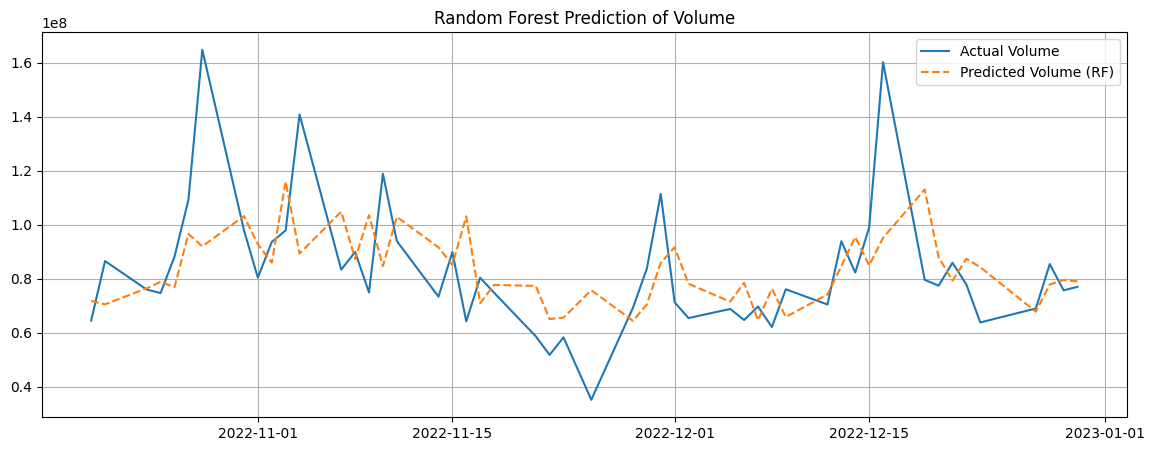

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test.values, label='Actual Volume')
plt.plot(y_test.index, y_pred_rf, label='Predicted Volume (RF)', linestyle='--')
plt.title('Random Forest Prediction of Volume')
plt.legend()
plt.grid(True)
plt.show()



**What the Plot Shows:**
  - **Blue Line:** Actual volume on test data.
  - **Orange Dashed Line:** Predicted volume by the Random Forest.
  - Good alignment between the lines shows that the model learned meaningful patterns from the lagged features.

**Interpretation:**
- Random Forest captures **non-linear relationships** in the volume series.
- It can detect complex interactions among lagged values without manual feature engineering.
- Suitable for short-term volume forecasting in liquid stocks.



## 4. Linear Regression

### Examples:
- **Multiple Linear Regression:** Include many predictors (e.g., price lags, macro data).
- **Regularized Regression (Ridge, Lasso):** Handle overfitting and multicollinearity.
- **Rolling Regression:** Update coefficients dynamically over time.

<br>

#### Common Use Cases  in Finance

- Stock Price Prediction
  - Predict future prices based on lagged prices, technical indicators (like moving averages, RSI), or macroeconomic variables.
  - Often used as a benchmark model before applying more complex machine learning models.

- Risk Modeling and Beta Estimation (CAPM)
  - Linear regression is used to calculate beta in the Capital Asset Pricing Model (CAPM)
  

- Predicting Trading Volume
  - As shown in our model below, we can use past volume data (lags) to predict future volume.
  - Useful for liquidity forecasting, market microstructure studies, and trading strategy design.

- Portfolio Optimization
  - Regression models can be used to estimate expected returns and covariances between assets, which are key inputs in mean-variance optimization.

<br>


For example below:
- **Model Used:** `LinearRegression`
- **RMSE:** Average error in prediction (like Random Forest, but using a linear model).
- **R² (R-squared):** Proportion of variance in volume explained by the lag features.
  - **R² = 1.0:** Perfect prediction.
  - **R² = 0.0:** No predictive value.
  - **Negative R²:** Model performs worse than simply predicting the average volume.



In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np # Import numpy for sqrt


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Calculate RMSE by taking the square root of the MSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear Regression RMSE: {rmse_lr:,.0f}")
print(f"R-squared: {r2_score(y_test, y_pred_lr):.4f}")

Linear Regression RMSE: 22,415,826
R-squared: 0.1082


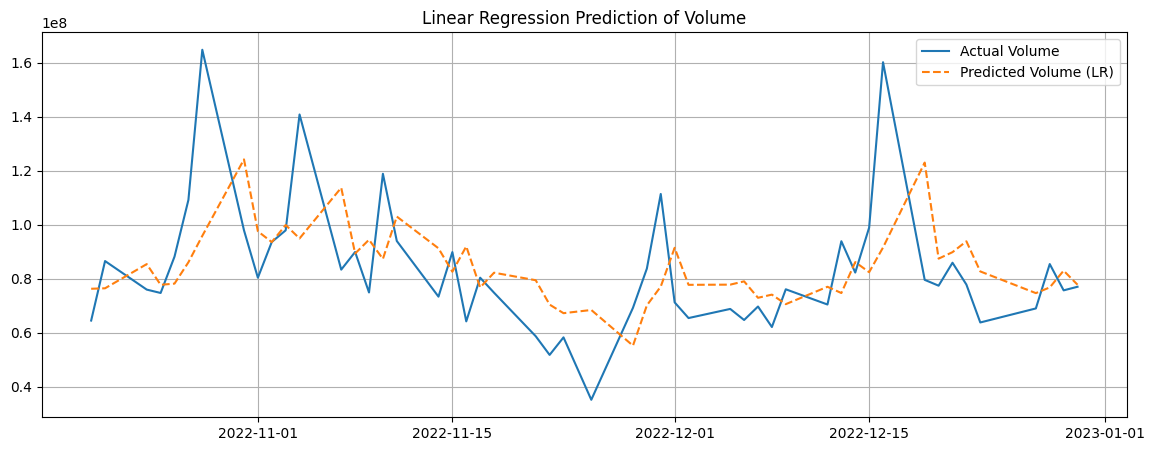

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test.values, label='Actual Volume')
plt.plot(y_test.index, y_pred_lr, label='Predicted Volume (LR)', linestyle='--')
plt.title('Linear Regression Prediction of Volume')
plt.legend()
plt.grid(True)
plt.show()


**Output Plot:**
  - Shows actual vs. predicted values from the linear regression model.

**Interpretation:**
- If the lines match well, it indicates a **linear relationship** between recent and future volume.
- If R² is low or negative, it suggests that:
  - Volume is not linearly predictable from its past values alone.
  - Other features (e.g., price indicators, time of week, news) may be required.


## 5. Seasonal Decomposition of Time Series (STL / Classical Decomposition)

**Purpose:** Separate volume into trend, seasonality, and residual (noise) components.

### Formula (Additive Model):
Volume_t = Trend_t + Seasonal_t + Residual_t


### Use Case:
- Detect regular patterns (e.g., end-of-week volume spikes).
- Improve anomaly detection and volume forecasting.




/tmp/ipython-input-18-4263436304.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2022-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


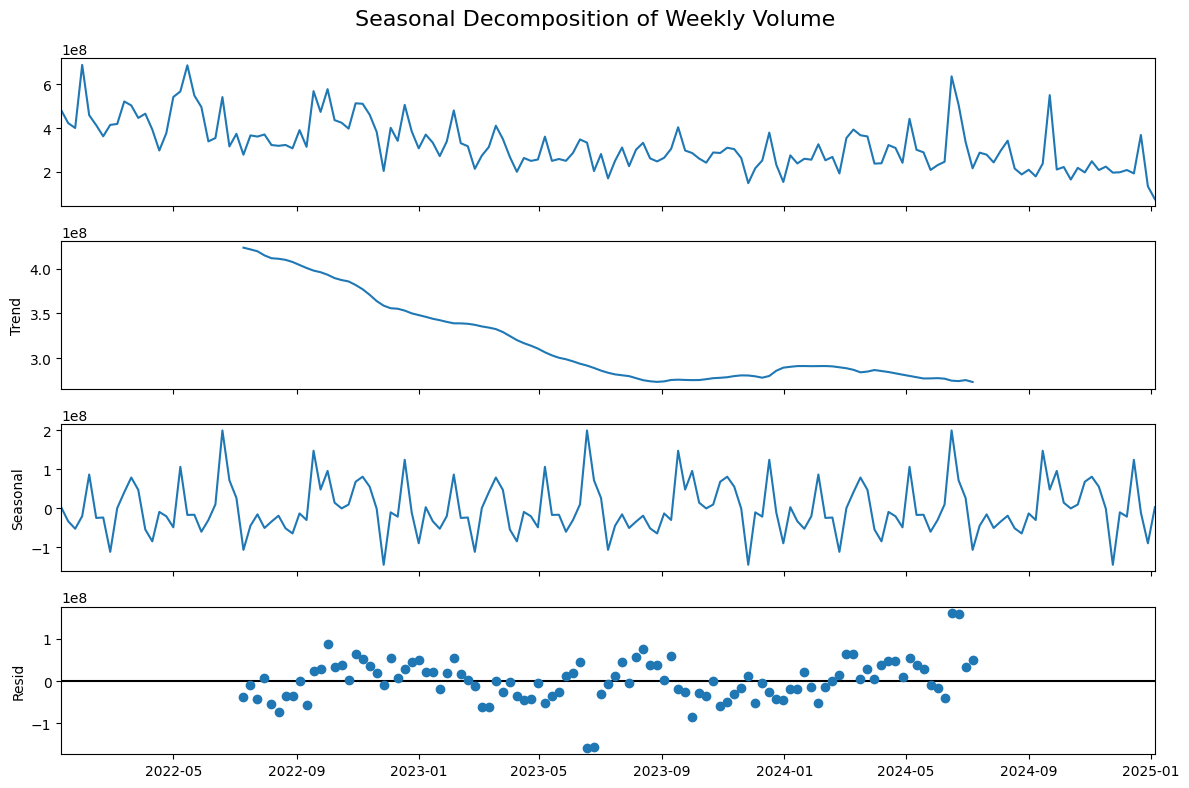

In [18]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 📥 Load daily data
data = yf.download('AAPL', start='2022-01-01', end='2025-01-01')
volume_daily = data['Volume'].dropna()

# 🗓️ Resample to weekly volume (sum of volume per week)
volume_weekly = volume_daily.resample('W').sum()

# 🧼 Ensure enough data points and no NaNs
volume_weekly = volume_weekly.dropna()

# 🧠 Apply seasonal decomposition (Additive model)
decomposition = seasonal_decompose(volume_weekly, model='additive', period=52)  # 52 weeks = 1 year

# 📊 Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Weekly Volume', fontsize=16)
plt.tight_layout()
plt.show()



### What the Plot Shows:

The output contains four time series plots stacked vertically:

1. **Observed:**
   - The actual weekly trading volume over time (raw input).
   - Helps visualize total fluctuations, trends, and spikes in activity.

2. **Trend:**
   - A smoothed version of the volume series showing the long-term direction.
   - Helps answer: *Is volume increasing or decreasing over months?*

3. **Seasonal:**
   - The repeating cyclical pattern extracted from the volume data.
   - Useful for detecting consistent **seasonal behaviors** like:
     - End-of-quarter surges
     - Pre-earnings accumulation
     - Regular mid-week volume spikes

4. **Residual:**
   - The “leftover” component after removing trend and seasonality.
   - Represents irregular, unexpected volume movements (noise).
   - Spikes here may signal **anomalies** (e.g., news, earnings surprises, geopolitical events).

<br>

### Interpretation:

- A **strong seasonal pattern** in volume means market participants tend to trade more/less in consistent intervals (e.g., quarterly, monthly).
- A **flat trend** suggests no directional bias in participation.
- **Large residual spikes** might indicate one-time events impacting volume.

<br>

Seasonal decomposition is essential in:

- **Cleaning signals:** Remove noise to build clearer indicators.
- **Volume forecasting:** Adjust models for recurring volume cycles.
- **Risk modeling:** Understand regular vs. abnormal market behavior.




## 6. Autocorrelation and Partial Autocorrelation (ACF & PACF)

**Purpose:** Identify time-lagged dependencies in volume data.

### Use case:
- Detect repeated patterns in trading volume.
- Determine ARIMA model parameters.



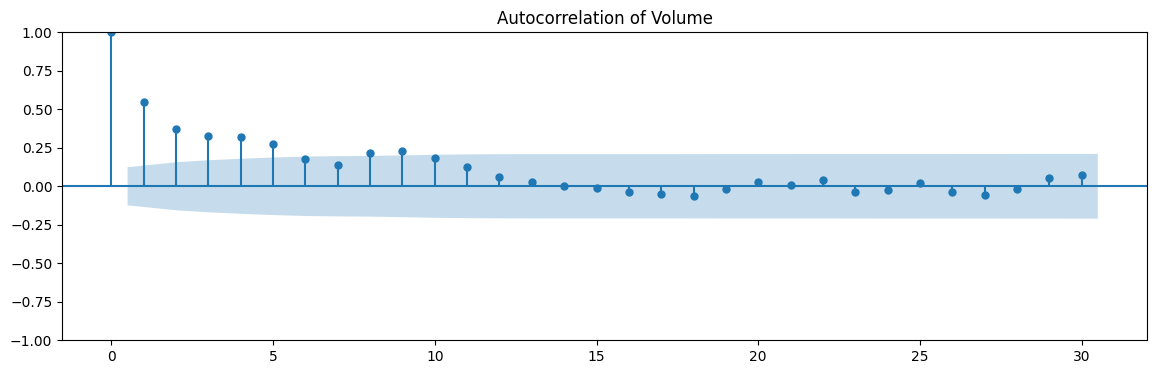

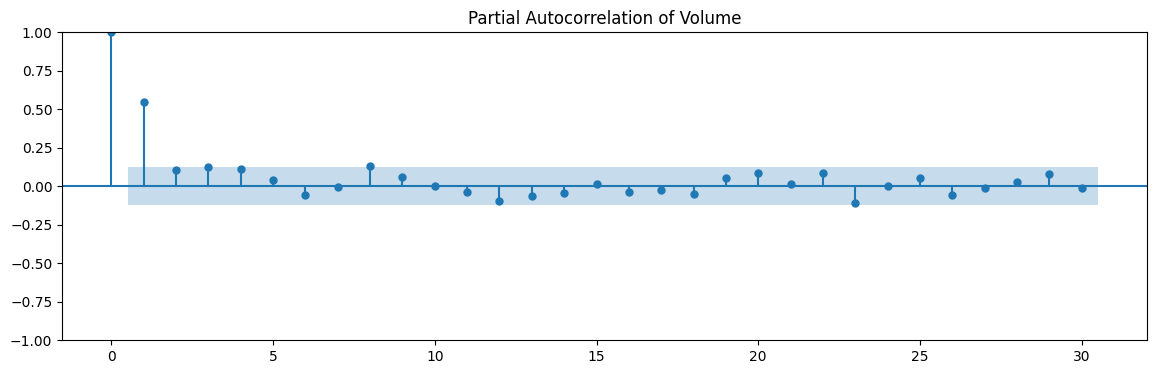

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 4))
plot_acf(volume.dropna(), lags=30, ax=plt.gca())
plt.title("Autocorrelation of Volume")
plt.show()

plt.figure(figsize=(14, 4))
plot_pacf(volume.dropna(), lags=30, ax=plt.gca())
plt.title("Partial Autocorrelation of Volume")
plt.show()


**Output Charts:**
- ACF and PACF bar plots showing correlation coefficients at various lags.

**Explanation:**
- **ACF**: Correlation between volume and its past values.
- **PACF**: Correlation controlling for intervening lags.
- Significant spikes indicate that volume at time \( t \) depends on volume at past time steps.
- Helps in selecting lag parameters for ARIMA models.




## 7. Fourier Transform

**Purpose:** Detect periodic components and hidden cycles in volume.

### Use Case:
- Capture cyclical volume trends (e.g., quarterly volume patterns).
- Useful in high-frequency trading and volume clustering.



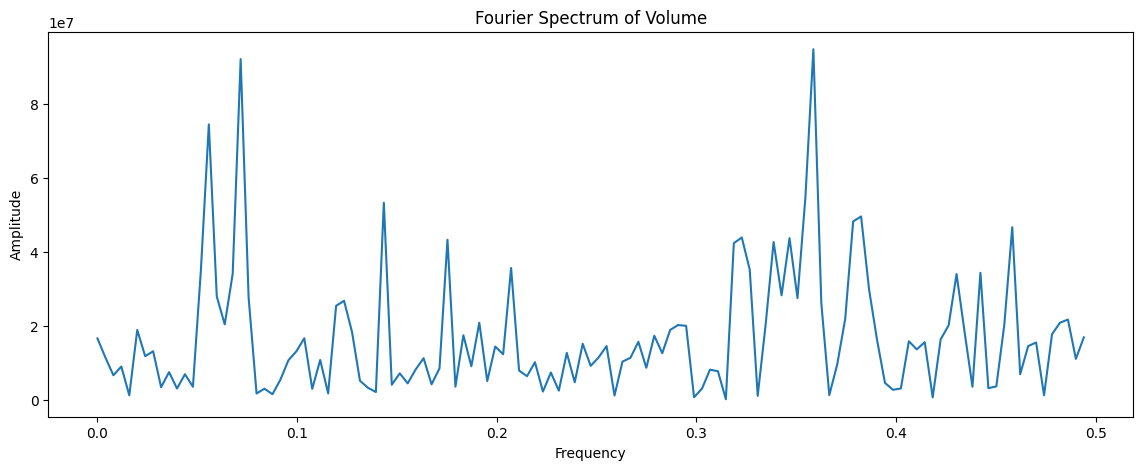

In [20]:
from numpy.fft import fft

volume_centered = volume - volume.mean()
fft_vals = fft(volume_centered)
frequencies = np.fft.fftfreq(len(fft_vals))

plt.figure(figsize=(14, 5))
plt.plot(frequencies[:len(frequencies)//2],
         np.abs(fft_vals)[:len(frequencies)//2])
plt.title('Fourier Spectrum of Volume')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


**Output Plot:**
- Amplitude spectrum of volume frequency components.

**Explanation:**
- Reveals dominant cycles in trading volume.
- Peaks represent repeating patterns — e.g., weekly or monthly volume spikes.
- Helps uncover **hidden periodic behavior** that isn’t obvious from raw data.


